#Aprendizaje Automático - TP 2: Regresión Logística

**Integrantes**

Dito, Daniela

Flaibani, Marcela

López Crespo, Facundo

#Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import KNNImputer

#Análisis Descriptivo

El dataset WeatherAUS.csv contiene información meteorológica histórica de diferentes estaciones de Australia.

* Date: La fecha en que se recogió la observación (formato YYYY-MM-DD).
* Location: Nombre de la estación meteorológica (ciudad o región en Australia).
* MinTemp: Temperatura mínima registrada en grados Celsius.
* MaxTemp: Temperatura máxima registrada en grados Celsius.
* Rainfall: Cantidad de lluvia registrada en el día, medida en milímetros.
* Evaporation: Cantidad de evaporación medida en milímetros.
* Sunshine: Horas de sol en el día.
* WindGustDir: Dirección del viento más fuerte registrado durante el día.
* WindGustSpeed: Velocidad del viento más fuerte registrado, en * kilómetros por hora.
* WindDir9am: Dirección del viento a las 9 de la mañana.
* WindDir3pm: Dirección del viento a las 3 de la tarde.
* WindSpeed9am: Velocidad del viento a las 9 de la mañana, en kilómetros por hora.
* WindSpeed3pm: Velocidad del viento a las 3 de la tarde, en kilómetros por hora.
* Humidity9am: Humedad relativa a las 9 de la mañana (porcentaje).
* Humidity3pm: Humedad relativa a las 3 de la tarde (porcentaje).
* Pressure9am: Presión atmosférica a las 9 de la mañana (en hPa).
* Pressure3pm: Presión atmosférica a las 3 de la tarde (en hPa).
* Cloud9am: Fracción de cielo nublado a las 9 de la mañana (medido en octavos).
* Cloud3pm: Fracción de cielo nublado a las 3 de la tarde (medido en octavos).
* Temp9am: Temperatura a las 9 de la mañana en grados Celsius.
* Temp3pm: Temperatura a las 3 de la tarde en grados Celsius.
* RainToday: Indicador si llovió en el día (Yes o No).
* RainTomorrow: Variable objetivo, indicando si lloverá el día siguiente (Yes o No).

In [2]:
# !gdown 1fY1TbF0bPZoHlxjYkLbeC6pY43keGUXu

In [3]:
# file_path= '/content/weatherAUS.csv'
file_path= 'weatherAUS.csv'
df_inicial = pd.read_csv(file_path, sep=',')

In [4]:
print(df_inicial.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

##Selección aleatoria de 10 ciudades del conjunto de datos.

In [5]:
# Establecer la semilla
np.random.seed(42)
ciudades = df_inicial['Location'].unique()
# Seleccionar 10 ciudades aleatorias
ciudades_aleatorias = np.random.choice(ciudades, size=10, replace=False)

# Convertir a una lista para fácil manejo
ciudades_seleccionadas = ciudades_aleatorias.tolist()

print(ciudades_seleccionadas)

['Williamtown', 'AliceSprings', 'Katherine', 'Launceston', 'MountGinini', 'Dartmoor', 'Watsonia', 'Portland', 'Townsville', 'Bendigo']


In [6]:
# Filtrar el DataFrame para quedarte solo con las filas de las ciudades seleccionadas
df_10 = df_inicial[df_inicial['Location'].isin(ciudades_seleccionadas)]

In [7]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28814 entries, 39538 to 143881
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           28814 non-null  object 
 1   Location       28814 non-null  object 
 2   MinTemp        28576 non-null  float64
 3   MaxTemp        28640 non-null  float64
 4   Rainfall       28084 non-null  float64
 5   Evaporation    18737 non-null  float64
 6   Sunshine       14632 non-null  float64
 7   WindGustDir    28040 non-null  object 
 8   WindGustSpeed  28043 non-null  float64
 9   WindDir9am     26551 non-null  object 
 10  WindDir3pm     28304 non-null  object 
 11  WindSpeed9am   28494 non-null  float64
 12  WindSpeed3pm   28498 non-null  float64
 13  Humidity9am    27982 non-null  float64
 14  Humidity3pm    27405 non-null  float64
 15  Pressure9am    24514 non-null  float64
 16  Pressure3pm    24517 non-null  float64
 17  Cloud9am       17919 non-null  float64
 18  C

##Eliminación de filas con target nula

In [8]:
df_10.isna().sum()

Date                 0
Location             0
MinTemp            238
MaxTemp            174
Rainfall           730
Evaporation      10077
Sunshine         14182
WindGustDir        774
WindGustSpeed      771
WindDir9am        2263
WindDir3pm         510
WindSpeed9am       320
WindSpeed3pm       316
Humidity9am        832
Humidity3pm       1409
Pressure9am       4300
Pressure3pm       4297
Cloud9am         10895
Cloud3pm         11650
Temp9am            602
Temp3pm           1111
RainToday          730
RainTomorrow       731
dtype: int64

Se eliminan las 713 filas con target ('RainTomorrow') nula.

In [9]:
# Se eliminan las 713 filas con valores nulos en la variable objetivo 'RainTomorrow'
df = df_10.dropna(subset=['RainTomorrow'])

# Mostrar el número de filas antes y después de la eliminación
print(f"Número de filas antes de eliminar: {len(df_10)}")
print(f"Número de filas después de eliminar: {len(df)}")
print(f"Número de filas eliminadas: {len(df_10) - len(df)}")

Número de filas antes de eliminar: 28814
Número de filas después de eliminar: 28083
Número de filas eliminadas: 731


In [10]:
df.isna().sum()

Date                 0
Location             0
MinTemp            130
MaxTemp             45
Rainfall           331
Evaporation       9614
Sunshine         13542
WindGustDir        535
WindGustSpeed      533
WindDir9am        2127
WindDir3pm         384
WindSpeed9am       201
WindSpeed3pm       192
Humidity9am        702
Humidity3pm       1267
Pressure9am       4092
Pressure3pm       4091
Cloud9am         10530
Cloud3pm         11281
Temp9am            473
Temp3pm            969
RainToday          331
RainTomorrow         0
dtype: int64

#Análisis Exploratorio

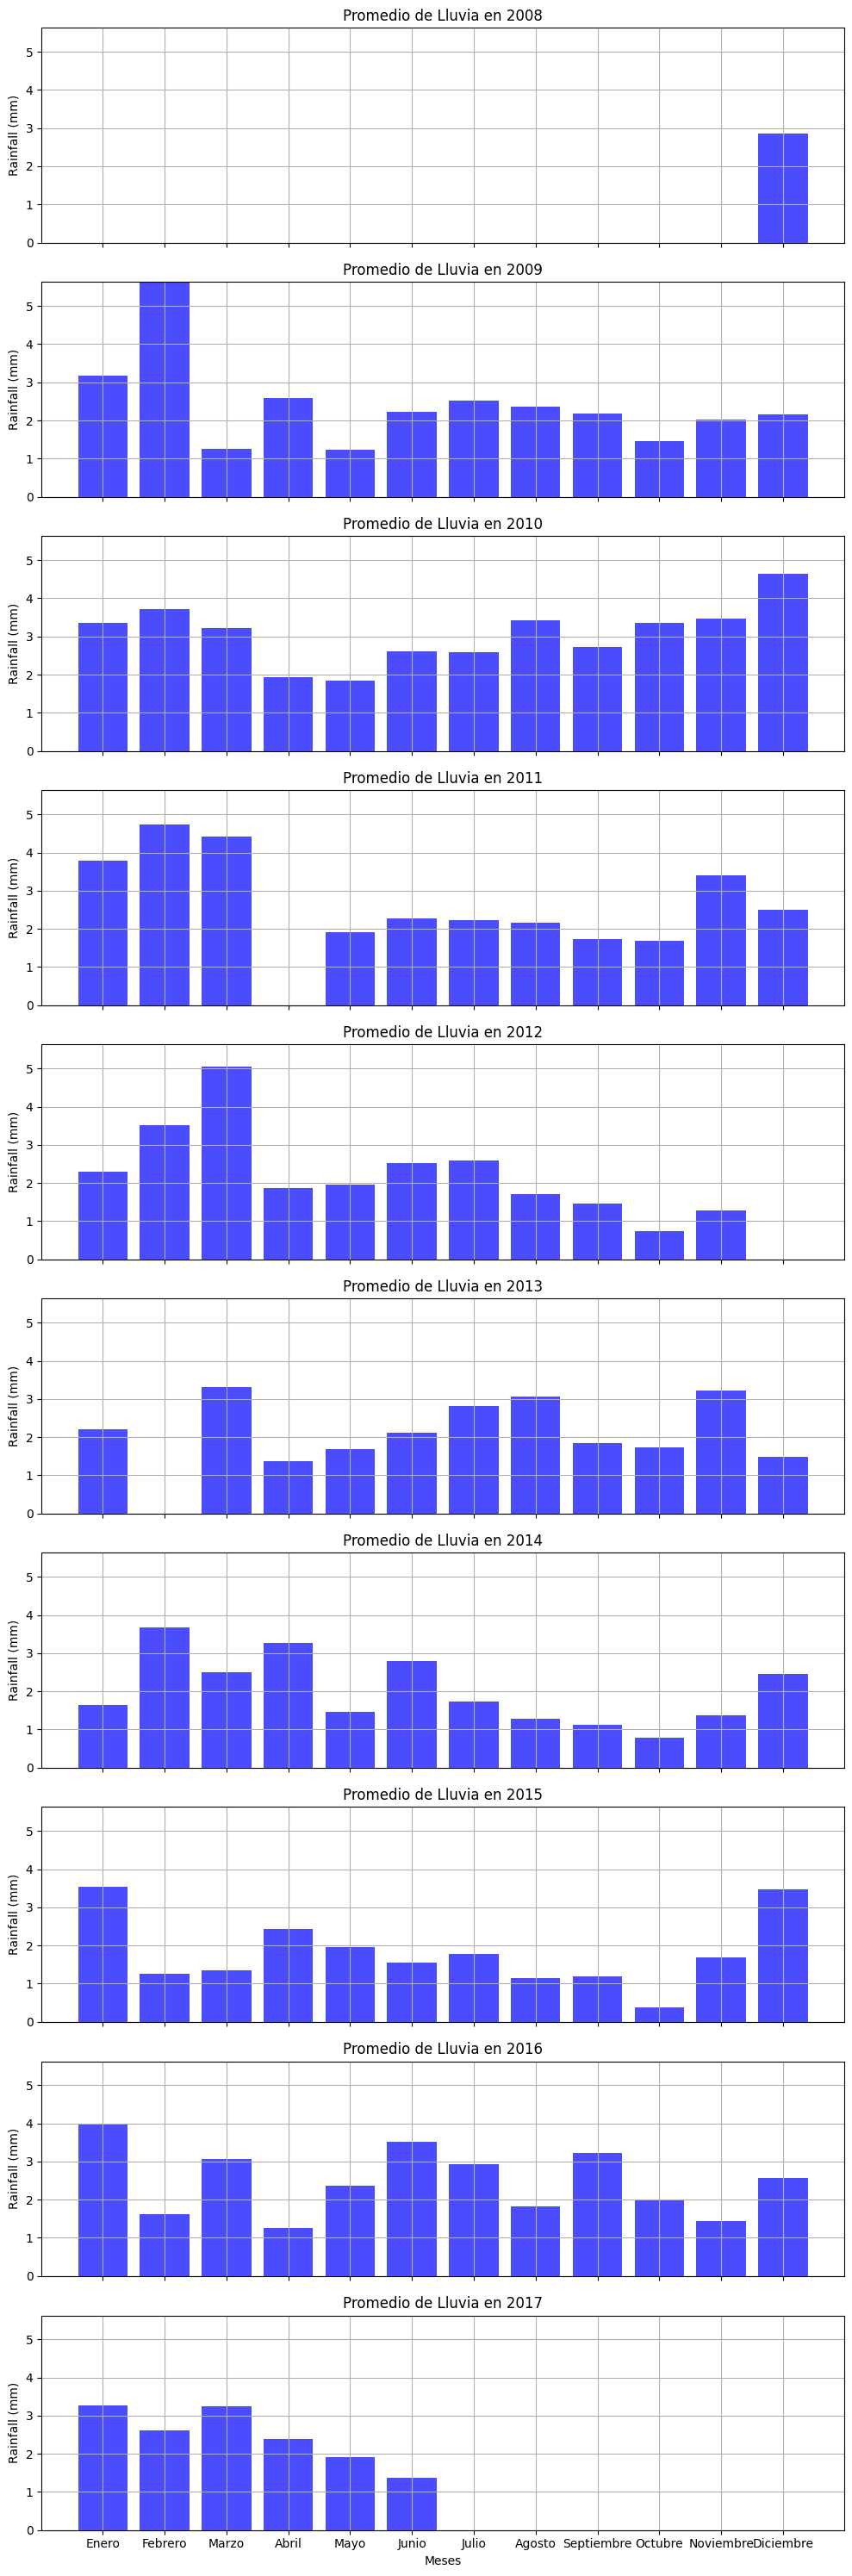

In [11]:
df_graficos = df.copy()
# Asegurarse de que la columna Date esté en formato datetime
df_graficos['Date'] = pd.to_datetime(df_graficos['Date'])

# Agregar columnas para Año y Mes
df_graficos['Year'] = df_graficos['Date'].dt.year
df_graficos['Month'] = df_graficos['Date'].dt.month

# Calcular la cantidad promedio de lluvia por mes y año
rainfall_per_year_month = df_graficos.groupby(['Year', 'Month'])['Rainfall'].mean().unstack()

# Graficar subplots, un año debajo de otro
years = rainfall_per_year_month.index  # Lista de años

# Crear subplots (uno por año)
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, len(years)*3), sharex=True)

# Si hay solo un año, convertir en lista para compatibilidad con axes
if len(years) == 1:
    axes = [axes]

for i, year in enumerate(years):
    axes[i].bar(rainfall_per_year_month.columns, rainfall_per_year_month.loc[year], color='b', alpha=0.7)
    axes[i].set_title(f'Promedio de Lluvia en {year}')
    axes[i].set_ylabel('Rainfall (mm)')
    axes[i].set_ylim(0, rainfall_per_year_month.max().max())  # Escala acorde al máximo valor de lluvia
    axes[i].grid(True)

# Etiquetas para los meses en el eje X
plt.xticks(ticks=range(1, 13), labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                                       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])

plt.xlabel('Meses')
plt.tight_layout()
plt.show()


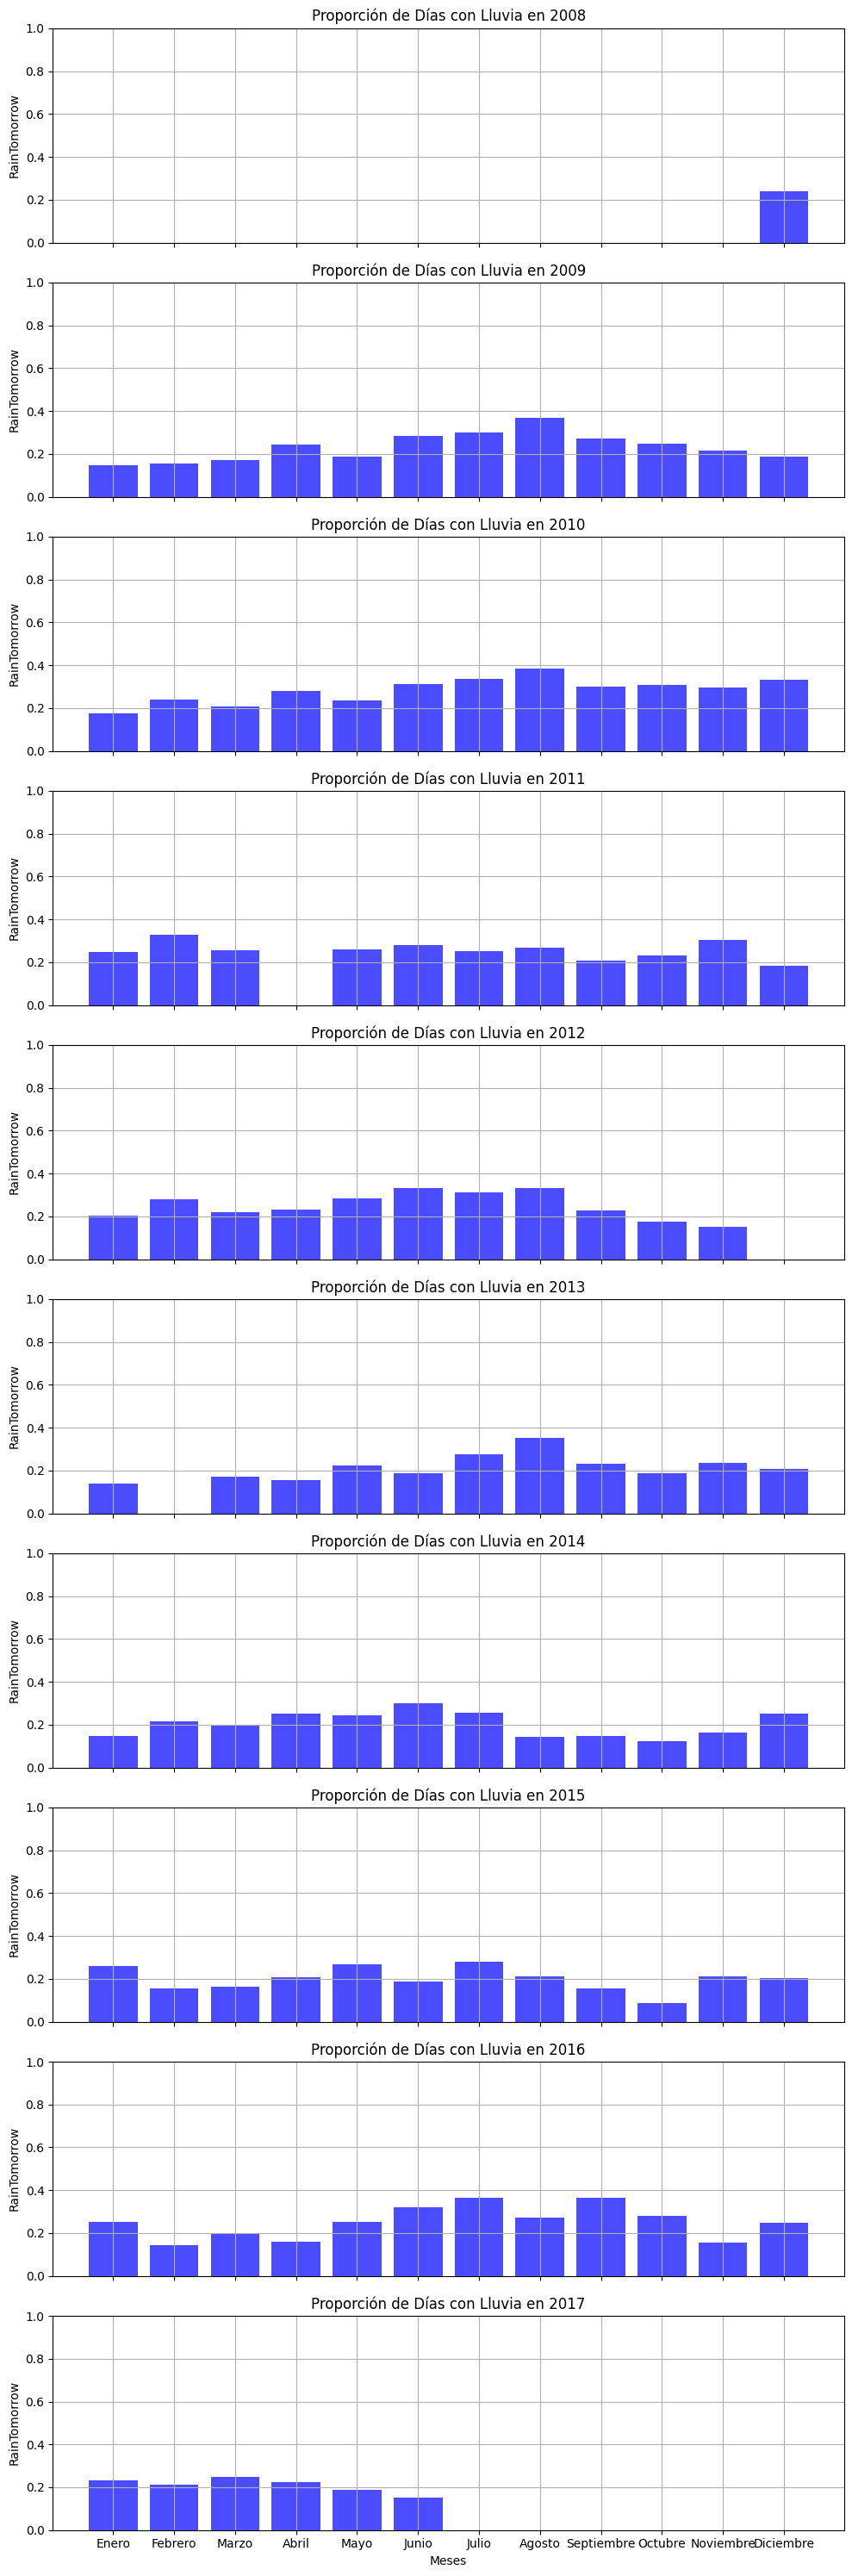

In [12]:
df_graficos = df.copy()
# Asegurarse de que la columna Date esté en formato datetime
df_graficos['Date'] = pd.to_datetime(df_graficos['Date'])

# Agregar columnas para Año y Mes
df_graficos['Year'] = df_graficos['Date'].dt.year
df_graficos['Month'] = df_graficos['Date'].dt.month

# Mapear "Yes" a 1 y "No" a 0 para la variable RainTomorrow
df_graficos['RainTomorrowNum'] = df_graficos['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Calcular la proporción de días con lluvia por mes y año
rain_per_year_month = df_graficos.groupby(['Year', 'Month'])['RainTomorrowNum'].mean().unstack()

# Graficar subplots, un año debajo de otro
years = rain_per_year_month.index  # Lista de años

# Crear subplots (uno por año)
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, len(years)*3), sharex=True)

# Si hay solo un año, convertir en lista para compatibilidad con axes
if len(years) == 1:
    axes = [axes]

for i, year in enumerate(years):
    axes[i].bar(rain_per_year_month.columns, rain_per_year_month.loc[year], color='b', alpha=0.7)
    axes[i].set_title(f'Proporción de Días con Lluvia en {year}')
    axes[i].set_ylabel('RainTomorrow')
    axes[i].set_ylim(0, 1)  # Ya que es una proporción de 0 a 1
    axes[i].grid(True)

# Etiquetas para los meses en el eje X
plt.xticks(ticks=range(1, 13), labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                                       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])

plt.xlabel('Meses')
plt.tight_layout()
plt.show()


##Separación del conjunto de datos en Train, Test (Y Val??)

Se separan los datos de entrenamiento y prueba de manera temporal, utilizando la variable Date, asignando los últimos 12 meses para el conjunto de prueba y los meses anteriores para el conjunto de entrenamiento.

Este enfoque es especialmente útil en problemas donde el tiempo influye en las predicciones (como la predicción de lluvia), ya que simula un escenario realista donde se entrena con datos históricos y se evalúa el modelo en datos más recientes.

In [13]:
df['Date'] = pd.to_datetime(df['Date'])

# Encontrar la fecha más reciente
fecha_final = df['Date'].max()
print(fecha_final)
# Restar 12 meses para determinar el punto de corte
fecha_corte = fecha_final - pd.DateOffset(months=12)
print(fecha_corte)

2017-06-25 00:00:00
2016-06-25 00:00:00


In [14]:
# Variables explicativas (X) y objetivo (y)
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Conjunto de entrenamiento (anterior a los últimos 12 meses)
X_train = X[X['Date'] < fecha_corte]
y_train = y[X['Date'] < fecha_corte]

# Conjunto de prueba (últimos 12 meses)
X_test = X[X['Date'] >= fecha_corte]
y_test = y[X['Date'] >= fecha_corte]

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24493, 22), (3590, 22), (24493,), (3590,))

Un 15% de los datos se utilizan para testeo

In [15]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,24385.000000,24454.000000,24196.000000,17085.000000,14181.000000,24041.000000,24301.000000,24306.000000,23808.000000,23584.000000,21128.000000,21130.000000,15634.000000,15231.000000,24033.000000,23879.000000
mean,11.022768,22.226953,2.373595,5.636564,7.428418,39.953746,13.298671,18.394141,70.842658,53.783879,1017.028895,1014.623871,4.392094,4.497013,15.989102,20.698434
std,7.059481,8.428166,8.528366,4.102260,3.891711,13.097148,8.223709,8.125462,21.685857,22.417300,7.257642,7.327376,2.930881,2.750080,7.668602,8.176841
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,1.000000,985.000000,980.200000,0.000000,0.000000,-6.200000,-5.100000
25%,6.100000,15.800000,0.000000,2.600000,4.300000,31.000000,7.000000,13.000000,59.000000,38.000000,1012.200000,1009.600000,1.000000,2.000000,10.500000,14.500000
50%,10.300000,21.400000,0.000000,5.000000,8.300000,39.000000,13.000000,19.000000,73.000000,55.000000,1017.100000,1014.500000,5.000000,5.000000,14.900000,19.900000
75%,15.600000,28.700000,0.800000,7.800000,10.700000,46.000000,19.000000,24.000000,89.000000,69.000000,1021.800000,1019.600000,7.000000,7.000000,21.500000,26.800000
max,30.300000,46.700000,236.800000,64.400000,14.300000,135.000000,65.000000,72.000000,100.000000,100.000000,1040.500000,1039.600000,8.000000,8.000000,39.100000,45.200000


Análisis del comportamiento de las variables

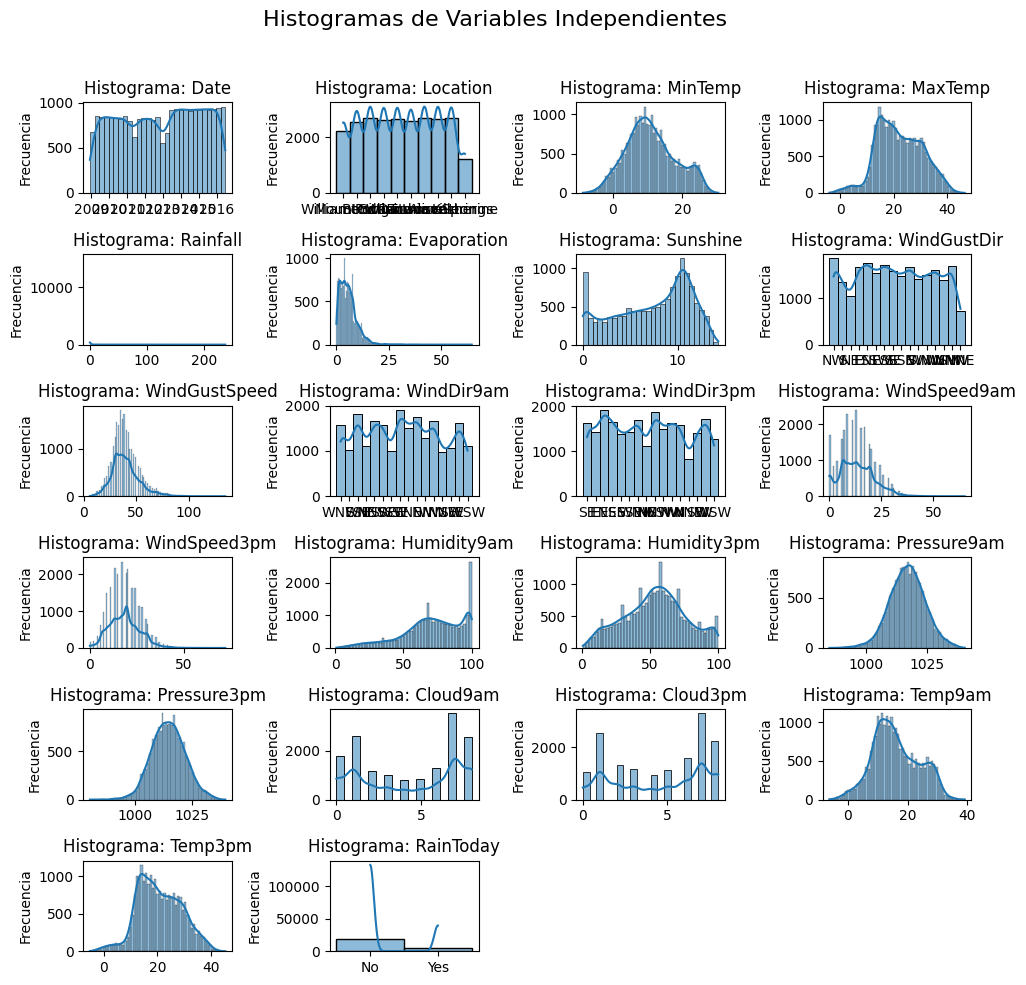

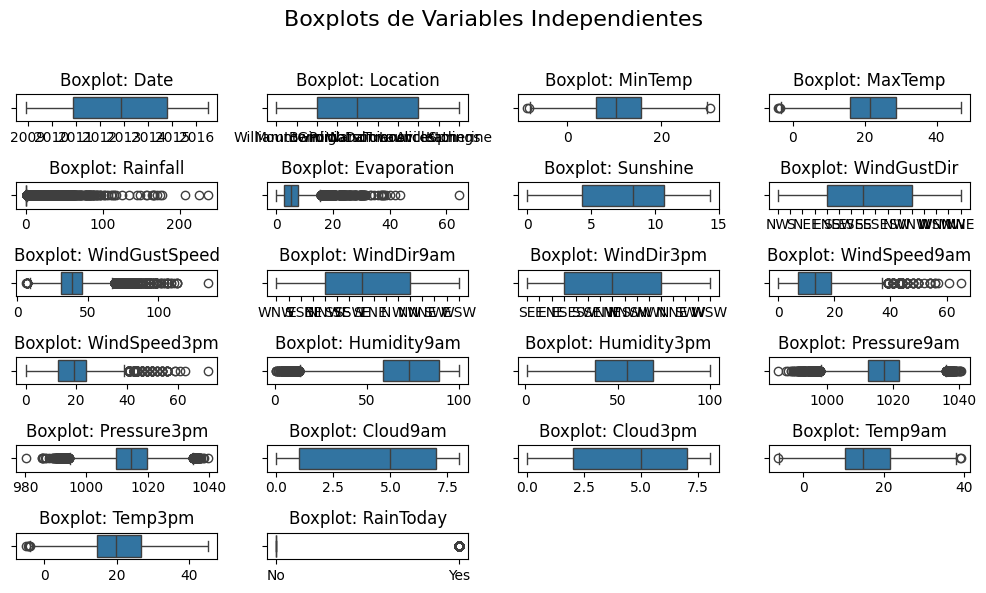

In [16]:
# Obtener nombres de las columnas (excluyendo el target)
independent_vars = X_train.columns

# Número de variables
num_vars = len(independent_vars)

# Calcular el número de filas y columnas necesario para el grid
cols = 4  # Fijas 4 columnas
rows = np.ceil(num_vars / cols).astype(int)  # Calcular número mínimo de filas necesarias

# Crear una figura con múltiples subgráficas para histogramas
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
fig.suptitle('Histogramas de Variables Independientes', fontsize=16)

for i, col in enumerate(independent_vars):
    ax = axes[i // cols, i % cols]
    sns.histplot(data=X_train, x=col, kde=True, ax=ax)
    ax.set_title(f'Histograma: {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia')

# Eliminar subplots vacíos si es necesario
if num_vars < rows * cols:
    for j in range(num_vars, rows * cols):
        fig.delaxes(axes.flatten()[j])

# Ajustar la disposición de los subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Crear una figura con múltiples subgráficas para boxplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
fig.suptitle('Boxplots de Variables Independientes', fontsize=16)

for i, col in enumerate(independent_vars):
    ax = axes[i // cols, i % cols]
    sns.boxplot(data=X_train, x=col, ax=ax)
    ax.set_title(f'Boxplot: {col}')
    ax.set_xlabel('')

# Eliminar subplots vacíos si es necesario
if num_vars < rows * cols:
    for j in range(num_vars, rows * cols):
        fig.delaxes(axes.flatten()[j])

# Ajustar la disposición de los subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [17]:
# # Correlación entre RainTomorrow y las variables predictivas
# df_train = pd.concat([X_train, y_train], axis=1)
# # df_test = pd.concat([X_test, y_test], axis=1)

# columnas = [col for col in df_train.columns if col != 'RainTomorrow']

# n_rows = 6
# n_cols = 4

# # Crear la figura y los subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))

# # Aplanar los ejes para recorrerlos en un solo bucle
# axes = axes.flatten()

# # Graficar cada variable de 'columnas' frente a 'RainTomorrow'
# for i, col in enumerate(columnas):
#     sns.scatterplot(data=df_train, x=col, y='RainTomorrow', ax=axes[i])
#     axes[i].set_title(f'{col} vs RainTomorrow')

# # Eliminar subplots vacíos si hay más subplots que columnas
# for j in range(i+1, n_rows * n_cols):
#     fig.delaxes(axes[j])

# # Ajustar el espaciado
# plt.tight_layout()
# plt.show()

##Imputación de valores nulos

In [18]:
print(f"\nNulos: {X_train.isnull().sum()}")


Nulos: Date                 0
Location             0
MinTemp            108
MaxTemp             39
Rainfall           297
Evaporation       7408
Sunshine         10312
WindGustDir        454
WindGustSpeed      452
WindDir9am        1904
WindDir3pm         361
WindSpeed9am       192
WindSpeed3pm       187
Humidity9am        685
Humidity3pm        909
Pressure9am       3365
Pressure3pm       3363
Cloud9am          8859
Cloud3pm          9262
Temp9am            460
Temp3pm            614
RainToday          297
dtype: int64


In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24493, 22), (24493,), (3590, 22), (3590,))

In [20]:
print(f"Máximo número de filas que pueden eliminarse: {round(len(X_train) * 5/100)}")

Máximo número de filas que pueden eliminarse: 1225


Se eliminan las filas con más de 8 valores nulos.

In [21]:
num_filas_con_mas_de_8_nulos = (X_train.isnull().sum(axis=1) > 8).sum()
print(f"Cantidad de filas con más de 8 valores nulos: {num_filas_con_mas_de_8_nulos}")

Cantidad de filas con más de 8 valores nulos: 369


In [22]:
# En train
i_filas_incompletas = X_train[X_train.isna().sum(axis=1) > 8].index

# Borrar las filas en X_train que tienen más de 8 valores nulos
X_train = X_train.drop(index=i_filas_incompletas)

# Borrar las mismas filas en y_train
y_train = y_train.drop(index=i_filas_incompletas)

X_train.shape, y_train.shape

((24124, 22), (24124,))

In [23]:
# En test
i_filas_incompletas = X_test[X_test.isna().sum(axis=1) > 8].index

# Borrar las filas en X_test que tienen más de 8 valores nulos
X_test = X_test.drop(index=i_filas_incompletas)

# Borrar las mismas filas en y_test
y_test = y_test.drop(index=i_filas_incompletas)

X_test.shape, y_test.shape

((3574, 22), (3574,))

In [24]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [25]:
print(f"\nNulos: {X_train.isnull().sum()}")


Nulos: Date                0
Location            0
MinTemp            41
MaxTemp            20
Rainfall          207
Evaporation      7042
Sunshine         9945
WindGustDir       316
WindGustSpeed     314
WindDir9am       1724
WindDir3pm        200
WindSpeed9am       16
WindSpeed3pm       28
Humidity9am       431
Humidity3pm       662
Pressure9am      3011
Pressure3pm      3011
Cloud9am         8492
Cloud3pm         8894
Temp9am           221
Temp3pm           381
RainToday         207
dtype: int64


Se eliminan las filas con Rainfall y RainToday nulas

In [26]:
# En train
i_rain_nulas = X_train[X_train[['Rainfall', 'RainToday']].isna().any(axis=1)].index

X_train = X_train.drop(index=i_rain_nulas)

# Borrar las mismas filas en y_train
y_train = y_train.drop(index=i_rain_nulas)

X_train.shape, y_train.shape

((23917, 22), (23917,))

In [27]:
# En test
i_rain_nulas = X_test[X_test[['Rainfall', 'RainToday']].isna().any(axis=1)].index

X_test = X_test.drop(index=i_rain_nulas)

# Borrar las mismas filas en y_test
y_test = y_test.drop(index=i_rain_nulas)

X_test.shape, y_test.shape

((3549, 22), (3549,))

In [28]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Cantidad de filas que se puede eliminar: 5% del total del dataset = 1225

Filas eliminadas por tener más de 8 valores nulos = 369

Filas eliminadas con 'Rainfall', 'RainToday' nulas = 207

Total de filas eliminadas = 576

In [29]:
X_train.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

In [30]:
# Inicializar el imputador
knn_imputer = KNNImputer(n_neighbors=3)

# Función para imputar con KNNImputer
def imputar_knn(columnas, X_train, X_test):
    X_train[columnas] = knn_imputer.fit_transform(X_train[columnas])
    X_test[columnas] = knn_imputer.transform(X_test[columnas])

# Función para imputar con la mediana
def imputar_mediana(columna, X_train, X_test):
    mediana = X_train[columna].median()
    X_train[columna] = X_train[columna].fillna(mediana)
    X_test[columna] = X_test[columna].fillna(mediana)

# Columnas a imputar con KNNImputer
columnas_knn = ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindSpeed9am',
                'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Aplicar imputación KNN a las columnas
imputar_knn(columnas_knn, X_train, X_test)

# Columnas a imputar con la mediana
columnas_mediana = ['Evaporation', 'WindGustSpeed', 'WindSpeed3pm',
                    'Pressure9am', 'Pressure3pm']

# Aplicar imputación con la mediana a las columnas
for columna in columnas_mediana:
    imputar_mediana(columna, X_train, X_test)

In [31]:
print(f"\nNulos: {X_train.isnull().sum()}")


Nulos: Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir       311
WindGustSpeed       0
WindDir9am       1717
WindDir3pm        200
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
dtype: int64


In [32]:
print(f"\nNulos: {X_test.isnull().sum()}")


Nulos: Date               0
Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustDir       73
WindGustSpeed      0
WindDir9am       219
WindDir3pm        22
WindSpeed9am       0
WindSpeed3pm       0
Humidity9am        0
Humidity3pm        0
Pressure9am        0
Pressure3pm        0
Cloud9am           0
Cloud3pm           0
Temp9am            0
Temp3pm            0
RainToday          0
dtype: int64


**COMO SE IMPUTAN LAS VARIABLES CATEGORICAS NULAS????**

## Escalado

##Codificación de las variables categóricas

**RainToday**

 Se mapea la variable categórica binaria 'RainToday' a 0 y 1

In [33]:
X_train['RainToday'] = X_train['RainToday'].map({'No': 0, 'Yes': 1})
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23917 entries, 0 to 23916
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           23917 non-null  datetime64[ns]
 1   Location       23917 non-null  object        
 2   MinTemp        23917 non-null  float64       
 3   MaxTemp        23917 non-null  float64       
 4   Rainfall       23917 non-null  float64       
 5   Evaporation    23917 non-null  float64       
 6   Sunshine       23917 non-null  float64       
 7   WindGustDir    23606 non-null  object        
 8   WindGustSpeed  23917 non-null  float64       
 9   WindDir9am     22200 non-null  object        
 10  WindDir3pm     23717 non-null  object        
 11  WindSpeed9am   23917 non-null  float64       
 12  WindSpeed3pm   23917 non-null  float64       
 13  Humidity9am    23917 non-null  float64       
 14  Humidity3pm    23917 non-null  float64       
 15  Pressure9am    2391

In [34]:
X_test['RainToday'] = X_test['RainToday'].map({'No': 0, 'Yes': 1})
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3549 entries, 0 to 3548
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3549 non-null   datetime64[ns]
 1   Location       3549 non-null   object        
 2   MinTemp        3549 non-null   float64       
 3   MaxTemp        3549 non-null   float64       
 4   Rainfall       3549 non-null   float64       
 5   Evaporation    3549 non-null   float64       
 6   Sunshine       3549 non-null   float64       
 7   WindGustDir    3476 non-null   object        
 8   WindGustSpeed  3549 non-null   float64       
 9   WindDir9am     3330 non-null   object        
 10  WindDir3pm     3527 non-null   object        
 11  WindSpeed9am   3549 non-null   float64       
 12  WindSpeed3pm   3549 non-null   float64       
 13  Humidity9am    3549 non-null   float64       
 14  Humidity3pm    3549 non-null   float64       
 15  Pressure9am    3549 n

**Date**

Year: variable contínua

Season: spring, autumn, summer y winter

En Australia, las estaciones están definidas por el calendario meteorológico y se basan en los meses del año. Las fechas de las estaciones son:

* Verano: del 1 de diciembre al 28 (o 29) de febrero.
* Otoño: del 1 de marzo al 31 de mayo.
* Invierno: del 1 de junio al 31 de agosto.
* Primavera: del 1 de septiembre al 30 de noviembre.

A diferencia de algunas partes del mundo donde las estaciones se basan en los solsticios y equinoccios, en Australia el comienzo de las estaciones está definido por meses completos, según el enfoque meteorológico.

In [35]:
# Convertir la columna 'Date' a formato datetime
X_train['Date'] = pd.to_datetime(X_train['Date'], format='%Y-%m-%d', errors='coerce')
X_train['Year'] = X_train['Date'].dt.year

X_test['Date'] = pd.to_datetime(X_test['Date'], format='%Y-%m-%d', errors='coerce')
X_test['Year'] = X_test['Date'].dt.year

In [ ]:
# Asignar un ángulo para cada dirección de viento en grados
angulo_grados = {
    'E': 0, 'ENE': 15, 'NE': 45, 'NNE': 75, 'N': 90, 'NNW': 105, 'NW': 135, 'WNW': 165,
    'W': 180, 'WSW': 195, 'SW': 225, 'SSW': 255, 'S': 270, 'SSE': 285, 'SE': 315, 'ESE': 345
}

# Función para convertir ángulo a coordenadas x, y gestionando NaN
def convertir_a_coordenadas(direccion):
    if pd.isna(direccion): 
        return pd.Series([np.nan, np.nan])  # Devolver NaN en ambas columnas
    angulo = np.deg2rad(angulo_grados[direccion])  # Convertir a radianes
    x = np.cos(angulo)  # viento_x
    y = np.sin(angulo)  # viento_y
    return pd.Series([x, y])

# Aplicar la conversión a coordenadas
X_train[['WindGustDir_x', 'WindGustDir_y']] = X_train['WindGustDir'].apply(convertir_a_coordenadas)
X_train[['WindDir9amr_x', 'WindDir9am_y']] = X_train['WindDir9am'].apply(convertir_a_coordenadas)
X_train[['WindDir3pmr_x', 'WindDir3pm_y']] = X_train['WindDir3pm'].apply(convertir_a_coordenadas)

X_test[['WindGustDir_x', 'WindGustDir_y']] = X_test['WindGustDir'].apply(convertir_a_coordenadas)
X_test[['WindDir9amr_x', 'WindDir9am_y']] = X_test['WindDir9am'].apply(convertir_a_coordenadas)
X_test[['WindDir3pmr_x', 'WindDir3pm_y']] = X_test['WindDir3pm'].apply(convertir_a_coordenadas)

X_train = X_train.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis = 1)
X_test = X_test.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis = 1)

print(X_train)
# No hay que escalar. Están en (0,1)
# Después imputar los nan con knn con variables numéricas(fit.transform en X_train y transform en X_test)

In [ ]:
# Convertir la columna 'Date' a formato datetime
X_train['Date'] = pd.to_datetime(X_train['Date'], format='%Y-%m-%d', errors='coerce')
X_train['Year'] = X_train['Date'].dt.year # ??
X_train['Month'] = X_train['Date'].dt.month

X_test['Date'] = pd.to_datetime(X_test['Date'], format='%Y-%m-%d', errors='coerce')
X_test['Year'] = X_test['Date'].dt.year # ??
X_test['Month'] = X_test['Date'].dt.month

# Asignar un ángulo para cada mes en grados
angulo_meses = {
    1: 0, 2: 30, 3: 60, 4: 90, 5: 120, 6: 150,
    7: 180, 8: 210, 9: 240, 10: 270, 11: 300, 12: 330
}

# Función para convertir el mes a coordenadas x, y
def convertir_mes_a_coordenadas(mes):
    # if pd.isna(mes):  # Verificar si el mes es NaN
    #     return pd.Series([np.nan, np.nan])  # Devolver NaN en ambas columnas
    angulo = np.deg2rad(angulo_meses[mes])  # Convertir a radianes
    x = np.cos(angulo)  # mes_x
    y = np.sin(angulo)  # mes_y
    return pd.Series([x, y])

# Aplicar la conversión a coordenadas, incluyendo NaN
X_train[['mes_x', 'mes_y']] = X_train['Month'].apply(convertir_mes_a_coordenadas)
X_test[['mes_x', 'mes_y']] = X_test['Month'].apply(convertir_mes_a_coordenadas)

print(X_train)
# No hay que escalar. Están en (0,1)
# Me parece que Date no tiene faltantes para imputar

In [36]:
def obtener_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:
        return 'winter'
    elif mes in [3, 4, 5]:
        return 'spring'
    elif mes in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

X_train['Season'] = X_train['Date'].apply(obtener_estacion)
X_train = X_train.drop(['Date'], axis = 1)

X_test['Season'] = X_test['Date'].apply(obtener_estacion)
X_test = X_test.drop(['Date'], axis = 1)
# X_train = pd.get_dummies(X_train, columns=['Season'], drop_first=True)  # Codificación dummies

**WindGustDir, WindDir9amRed, WindDir3pmRed**

Norte (N): incluye 'N', 'NNE', 'NNW'

Sur (S): incluye 'S', 'SSE', 'SSW'

Este (E): incluye 'E', 'ENE', 'ESE'

Oeste (W): incluye 'W', 'WNW', 'WSW'

Noreste (NE): incluye 'NE'

Noroeste (NW): incluye 'NW'

Sureste (SE): incluye 'SE'

Suroeste (SW): incluye 'SW'

In [37]:
X_train['WindGustDir'].unique()

array(['NW', 'S', 'NE', 'E', 'ENE', 'SSW', 'ESE', nan, 'SE', 'SSE', 'N',
       'SW', 'WNW', 'W', 'WSW', 'NNW', 'NNE'], dtype=object)

In [38]:
# Re-clasificación
wind_dir_map = {
    'N': 'N', 'NNE': 'N', 'NNW': 'N',  # Grupo 'Norte'
    'S': 'S', 'SSE': 'S', 'SSW': 'S',  # Grupo 'Sur'
    'E': 'E', 'ENE': 'E', 'ESE': 'E',  # Grupo 'Este'
    'W': 'W', 'WNW': 'W', 'WSW': 'W',  # Grupo 'Oeste'
    'NE': 'NE',  # Grupo 'Noreste'
    'NW': 'NW',  # Grupo 'Noroeste'
    'SE': 'SE',  # Grupo 'Sureste'
    'SW': 'SW'   # Grupo 'Suroeste'
}

# Función para reclasificar columnas de dirección del viento
def reclasificar_viento(columna):
    return X_train[columna].map(wind_dir_map)

X_train['WindGustDirRedu'] = reclasificar_viento('WindGustDir')
X_train['WindDir9amRedu'] = reclasificar_viento('WindDir9am')
X_train['WindDir3pmRedu'] = reclasificar_viento('WindDir3pm')

X_test['WindGustDirRedu'] = reclasificar_viento('WindGustDir')
X_test['WindDir9amRedu'] = reclasificar_viento('WindDir9am')
X_test['WindDir3pmRedu'] = reclasificar_viento('WindDir3pm')

In [39]:
X_train = X_train.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis = 1)
X_test = X_test.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis = 1)

In [40]:
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Season,WindGustDirRedu,WindDir9amRedu,WindDir3pmRedu
0,Williamtown,15.2,34.0,0.0,11.6,9.200000,41.0,17.0,20.0,62.0,...,3.0,6.000000,23.7,28.700000,0,2009,winter,NW,W,SE
1,Williamtown,18.3,24.5,0.0,8.8,9.400000,54.0,13.0,30.0,61.0,...,3.0,2.000000,21.6,23.400000,0,2009,winter,S,S,E
2,Williamtown,16.8,23.5,0.4,8.4,0.400000,37.0,19.0,22.0,60.0,...,7.0,7.000000,20.1,21.700000,0,2009,winter,NE,E,E
3,Williamtown,17.5,27.8,0.0,5.0,12.000000,50.0,19.0,35.0,60.0,...,1.0,1.000000,22.7,26.400000,0,2009,winter,E,NE,E
4,Williamtown,14.8,36.0,0.0,8.6,11.900000,37.0,15.0,26.0,67.0,...,2.0,3.000000,22.5,33.800000,0,2009,winter,E,N,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23912,Katherine,15.5,30.7,0.0,7.2,11.433333,35.0,20.0,4.0,51.0,...,0.0,2.000000,22.0,30.533333,0,2016,summer,E,E,W
23913,Katherine,11.4,31.0,0.0,5.4,11.800000,30.0,0.0,13.0,56.0,...,0.0,3.666667,19.3,28.366667,0,2016,summer,S,NaN,SE
23914,Katherine,10.0,32.5,0.0,5.0,7.800000,30.0,13.0,15.0,55.0,...,0.0,0.666667,19.5,30.833333,0,2016,summer,SE,SE,SE
23915,Katherine,10.0,34.0,0.0,5.8,10.933333,20.0,11.0,11.0,51.0,...,0.0,1.333333,19.5,31.933333,0,2016,summer,E,SE,E


In [41]:
# # Codificar las variables categóricas en X_train
# encoder = OneHotEncoder(handle_unknown='ignore')
# X_train_encoded = encoder.fit_transform(X_train)

# # Aplicar la misma codificación en X_test
# X_test_encoded = encoder.transform(X_test)


In [42]:
# # Definir las columnas categóricas
# categorical_columns = ['Location', 'WindGustDirRedu', 'WindDir9amRedu', 'WindDir3pmRedu', 'Season']

# # Configurar el transformador para codificar solo las variables categóricas
# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'), categorical_columns)], remainder='passthrough')

# # Codificar el conjunto de entrenamiento
# X_train_encoded = ct.fit_transform(X_train)

# # Codificar el conjunto de prueba
# X_test_encoded = ct.transform(X_test)


In [43]:
# Definir las columnas categóricas
categorical_columns = ['Location', 'WindGustDirRedu', 'WindDir9amRedu', 'WindDir3pmRedu', 'Season']

# Configurar el transformador para codificar solo las variables categóricas
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'), categorical_columns)], remainder='passthrough')

# Codificar el conjunto de entrenamiento
X_train_encoded = ct.fit_transform(X_train)

# Obtener los nombres de las nuevas columnas codificadas
new_column_names = ct.get_feature_names_out()

# Convertir el array codificado a DataFrame con los nombres de columnas
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=new_column_names)

# Aplicar lo mismo para X_test
X_test_encoded = ct.transform(X_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=new_column_names)


In [44]:
X_train_encoded.shape, X_test_encoded.shape

((23917, 54), (3549, 54))

In [45]:
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Season,WindGustDirRedu,WindDir9amRedu,WindDir3pmRedu
0,Williamtown,15.2,34.0,0.0,11.6,9.200000,41.0,17.0,20.0,62.0,...,3.0,6.000000,23.7,28.700000,0,2009,winter,NW,W,SE
1,Williamtown,18.3,24.5,0.0,8.8,9.400000,54.0,13.0,30.0,61.0,...,3.0,2.000000,21.6,23.400000,0,2009,winter,S,S,E
2,Williamtown,16.8,23.5,0.4,8.4,0.400000,37.0,19.0,22.0,60.0,...,7.0,7.000000,20.1,21.700000,0,2009,winter,NE,E,E
3,Williamtown,17.5,27.8,0.0,5.0,12.000000,50.0,19.0,35.0,60.0,...,1.0,1.000000,22.7,26.400000,0,2009,winter,E,NE,E
4,Williamtown,14.8,36.0,0.0,8.6,11.900000,37.0,15.0,26.0,67.0,...,2.0,3.000000,22.5,33.800000,0,2009,winter,E,N,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23912,Katherine,15.5,30.7,0.0,7.2,11.433333,35.0,20.0,4.0,51.0,...,0.0,2.000000,22.0,30.533333,0,2016,summer,E,E,W
23913,Katherine,11.4,31.0,0.0,5.4,11.800000,30.0,0.0,13.0,56.0,...,0.0,3.666667,19.3,28.366667,0,2016,summer,S,NaN,SE
23914,Katherine,10.0,32.5,0.0,5.0,7.800000,30.0,13.0,15.0,55.0,...,0.0,0.666667,19.5,30.833333,0,2016,summer,SE,SE,SE
23915,Katherine,10.0,34.0,0.0,5.8,10.933333,20.0,11.0,11.0,51.0,...,0.0,1.333333,19.5,31.933333,0,2016,summer,E,SE,E


In [46]:
X_train_encoded_df

,encoder__Location_Bendigo,encoder__Location_Dartmoor,encoder__Location_Katherine,encoder__Location_Launceston,encoder__Location_MountGinini,encoder__Location_Portland,encoder__Location_Townsville,encoder__Location_Watsonia,encoder__Location_Williamtown,encoder__WindGustDirRedu_N,...,remainder__Humidity9am,remainder__Humidity3pm,remainder__Pressure9am,remainder__Pressure3pm,remainder__Cloud9am,remainder__Cloud3pm,remainder__Temp9am,remainder__Temp3pm,remainder__RainToday,remainder__Year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,62.0,36.000000,1005.2,1001.5,3.0,6.000000,23.7,28.700000,0.0,2009.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,61.0,57.000000,1012.1,1011.7,3.0,2.000000,21.6,23.400000,0.0,2009.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,60.0,58.000000,1020.4,1018.4,7.0,7.000000,20.1,21.700000,0.0,2009.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,60.0,51.000000,1018.4,1014.6,1.0,1.000000,22.7,26.400000,0.0,2009.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,67.0,39.000000,1013.6,1008.7,2.0,3.000000,22.5,33.800000,0.0,2009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23912,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.0,24.000000,1014.9,1010.5,0.0,2.000000,22.0,30.533333,0.0,2016.0
23913,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,22.000000,1014.1,1010.0,0.0,3.666667,19.3,28.366667,0.0,2016.0
23914,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.0,26.666667,1014.9,1009.9,0.0,0.666667,19.5,30.833333,0.0,2016.0
23915,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.0,14.000000,1013.9,1009.4,0.0,1.333333,19.5,31.933333,0.0,2016.0


In [47]:
X_train_encoded_df.columns

Index(['encoder__Location_Bendigo', 'encoder__Location_Dartmoor',
       'encoder__Location_Katherine', 'encoder__Location_Launceston',
       'encoder__Location_MountGinini', 'encoder__Location_Portland',
       'encoder__Location_Townsville', 'encoder__Location_Watsonia',
       'encoder__Location_Williamtown', 'encoder__WindGustDirRedu_N',
       'encoder__WindGustDirRedu_NE', 'encoder__WindGustDirRedu_NW',
       'encoder__WindGustDirRedu_S', 'encoder__WindGustDirRedu_SE',
       'encoder__WindGustDirRedu_SW', 'encoder__WindGustDirRedu_W',
       'encoder__WindGustDirRedu_nan', 'encoder__WindDir9amRedu_N',
       'encoder__WindDir9amRedu_NE', 'encoder__WindDir9amRedu_NW',
       'encoder__WindDir9amRedu_S', 'encoder__WindDir9amRedu_SE',
       'encoder__WindDir9amRedu_SW', 'encoder__WindDir9amRedu_W',
       'encoder__WindDir9amRedu_nan', 'encoder__WindDir3pmRedu_N',
       'encoder__WindDir3pmRedu_NE', 'encoder__WindDir3pmRedu_NW',
       'encoder__WindDir3pmRedu_S', 'encoder__Win

In [48]:
# # Identificar variables numéricas y categóricas
# num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
# cat_features = X_train.select_dtypes(include=['object']).columns

# # Crear imputadores para numéricas y categóricas
# num_imputer = SimpleImputer(strategy='mean')  # O mediana o KNN
# cat_imputer = SimpleImputer(strategy='most_frequent')  # Moda para categóricas

# # Crear transformadores para One-Hot Encoding y escalado
# ohe = OneHotEncoder(handle_unknown='ignore')
# scaler = StandardScaler()

# # Crear un preprocesador que aplica las imputaciones y transformaciones
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline(steps=[
#             ('imputer', num_imputer),
#             ('scaler', scaler)
#         ]), num_features),
#         ('cat', Pipeline(steps=[
#             ('imputer', cat_imputer),
#             ('onehot', ohe)
#         ]), cat_features)
#     ]
# )

# # Aplicar el preprocesador al conjunto de entrenamiento y prueba
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)
